In [37]:
# work environment: jl2815
import pandas as pd
import numpy as np
from collections import defaultdict
import math
from scipy.special import gamma  # better than math.gamma(v)
# from skgstat import Variogram

from typing import Callable   # nearest neighbor function input type
import sklearn.neighbors  # nearest neighbor

from sklearn.neighbors import BallTree # for space_center function


import scipy
from scipy.stats import multivariate_normal #simulation
from scipy.optimize import minimize
from scipy.special import kv                # bessel function


import matplotlib.pyplot as plt
import seaborn as sns
import concurrent.futures
import sys

from scipy.spatial.distance import cdist # for space and time distance
from scipy.spatial import distance # find closest spatial point

from typing import Callable, Union   # nearest neighbor function input type
from typing import Tuple

sys.path.append("/cache/home/jl2815/tco")

from GEMS_TCO import orbitmap
# from GEMS_TCO import smoothspace
from GEMS_TCO.smoothspace import space_average

import argparse
import logging

In [38]:
def maxmin_naive(dist: np.ndarray, first: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Performs min-max ordering

    The implementation is naive and will not perform well for large inputs.

    Parameters
    ----------
    dist
        distance matrix
    first
        Index of the observation that should be sorted first

    Returns
    -------
    np.ndarray
        The minmax ordering
    np.ndarray
        Array with the distances to the location preceding in ordering
    """

    n = dist.shape[0]
    ord = np.zeros(n, dtype=np.int64)
    ord[0] = first
    dists = np.zeros(n)
    dists[0] = np.nan
    idx = np.arange(n)


    for i in range(1, n):
        # find min dist for each not selected loccation
        mask = ~np.isin(idx, ord[:i])
        min_d = np.min(dist[mask, :][:, ord[:i]], axis=1)

        # find max idx among those
        idx_max = np.argmax(min_d)

        # record dist
        dists[i] = min_d[idx_max]

        # adjust idx for the prevous removed rows
        idx_max = idx[mask][idx_max]
        ord[i] = idx_max
    return ord, dists


def find_nns_naive(
    locs: np.ndarray, dist_fun: Union[Callable, str] = "euclidean", max_nn: int = 10, **kwargs
) -> np.ndarray:
    """
    Finds the max_nn nearest neighbors preceding in the ordering.

    The method is naivly implemented and will not perform well for large inputs.

    Parameters
    ----------
    locs
        an n x m array of ordered locations
    dist_fun
        a distance function
    max_nn
        number of nearest neighbours
    kwargs
        supplied dist_func

    Returns
    -------
    np.ndarray
        Returns an n x max_nn array holding the indices of the nearest neighbors
        preceding in the ordering where -1 indicates missing neighbors.
    """

    n = locs.shape[0]
    nns = np.zeros((n, max_nn), dtype=np.int64) - 1
    for i in range(1, n):
        nn = sklearn.neighbors.BallTree(locs[:i], metric=dist_fun, **kwargs)   # dist_fun= 'euclidean'
        k = min(i-1, max_nn)
        nn_res = nn.query(locs[[i], :], k=k, return_distance=False)
        nns[i, :k] = nn_res
    return nns

In [39]:
df = pd.read_csv("C:\\Users\\joonw\\TCO\\data_engineering\\data_24_07_0130_N510_E110120.csv")

resolution = 0.2 

instance = orbitmap.MakeOrbitdata(df,resolution,resolution,5,10,110,120)   # lat_s,lat_e, lon_s, lon_e
orbit_map24_7 = instance.makeorbitmap()

# instance24_7 = orbitmap.MakeOrbitdata(df,10,20,120,135)
sparse_map_24_7 = instance.make_sparsemap(orbit_map24_7,resolution)

In [40]:
## given data hash map, group them by days, so that each day contains 8 orbits
keys = sorted(sparse_map_24_7)
grp = defaultdict(list)
keys_idx = list(range(240))
grouped_data = [ keys_idx[i:i + 8] for i in range(0, len(keys_idx), 8)]
for i in range(len(grouped_data)):
    data = None
    for idx in grouped_data[i]:
        if data is not None:
            data = pd.concat([data, sparse_map_24_7[ keys[idx]] ] , axis=0)
        else:
            data = sparse_map_24_7[keys[idx]]
    grp[i] = data.reset_index(drop=True)

orbitsize = int(len(grp[0])/8)

# Extract values from sample data, baseic spatial unit to extract max min order
sample_data = grp[0].iloc[:orbitsize]
x1 = sample_data['Longitude'].values
y1 = sample_data['Latitude'].values 
coords1 = np.stack((x1, y1), axis=-1)
s_dist = cdist(coords1, coords1, 'euclidean')

ord_mm, _ = maxmin_naive(s_dist, 0)
# Construct nearest neighboring set
# nns_map = find_nns_naive(locs= coords1, dist_fun= 'euclidean', max_nn= mm_cond_number)


# Reorder the DataFrame so that we can make nns_map based on the same order
sample_data = sample_data.iloc[ord_mm].reset_index(drop=True)  
coords1_reordered = np.stack((sample_data['Longitude'].values, sample_data['Latitude'].values), axis=-1)


orbits = grp[0]['Orbit'].unique()
orbit_num = len(orbits) 
obs_per_orbit = int(len(grp[0])/orbit_num)
order_for_8_orbits = np.concatenate( [np.array(ord_mm)+ i*obs_per_orbit for i in range(orbit_num) ])


# Reorder each data set in 30 days
for i in range(len(grouped_data)):
    if order_for_8_orbits.max() >= len(grp[i]):
        print(f"Index out of bounds for grp[{i}]. Size: {len(grp[i])}, Max index: {order_for_8_orbits.max()}")
        continue

    grp[i] = grp[i].iloc[order_for_8_orbits].reset_index(drop=True)

# clip

In [41]:
import numpy as np
keys = sorted(sparse_map_24_7)
for key in keys:
    # Create a combined mask using logical OR
    mask = (sparse_map_24_7[key]['ColumnAmountO3'] < 200) | (sparse_map_24_7[key]['ColumnAmountO3'] > 500)
    # Filter the DataFrame to exclude rows where mask is True
    df = sparse_map_24_7[key][~mask]
    # Calculate the mean of the remaining 'ColumnAmountO3'
    mean_value = np.mean(df['ColumnAmountO3'])
    # Replace values where mask is True with the calculated mean
    sparse_map_24_7[key].loc[mask, 'ColumnAmountO3'] = mean_value


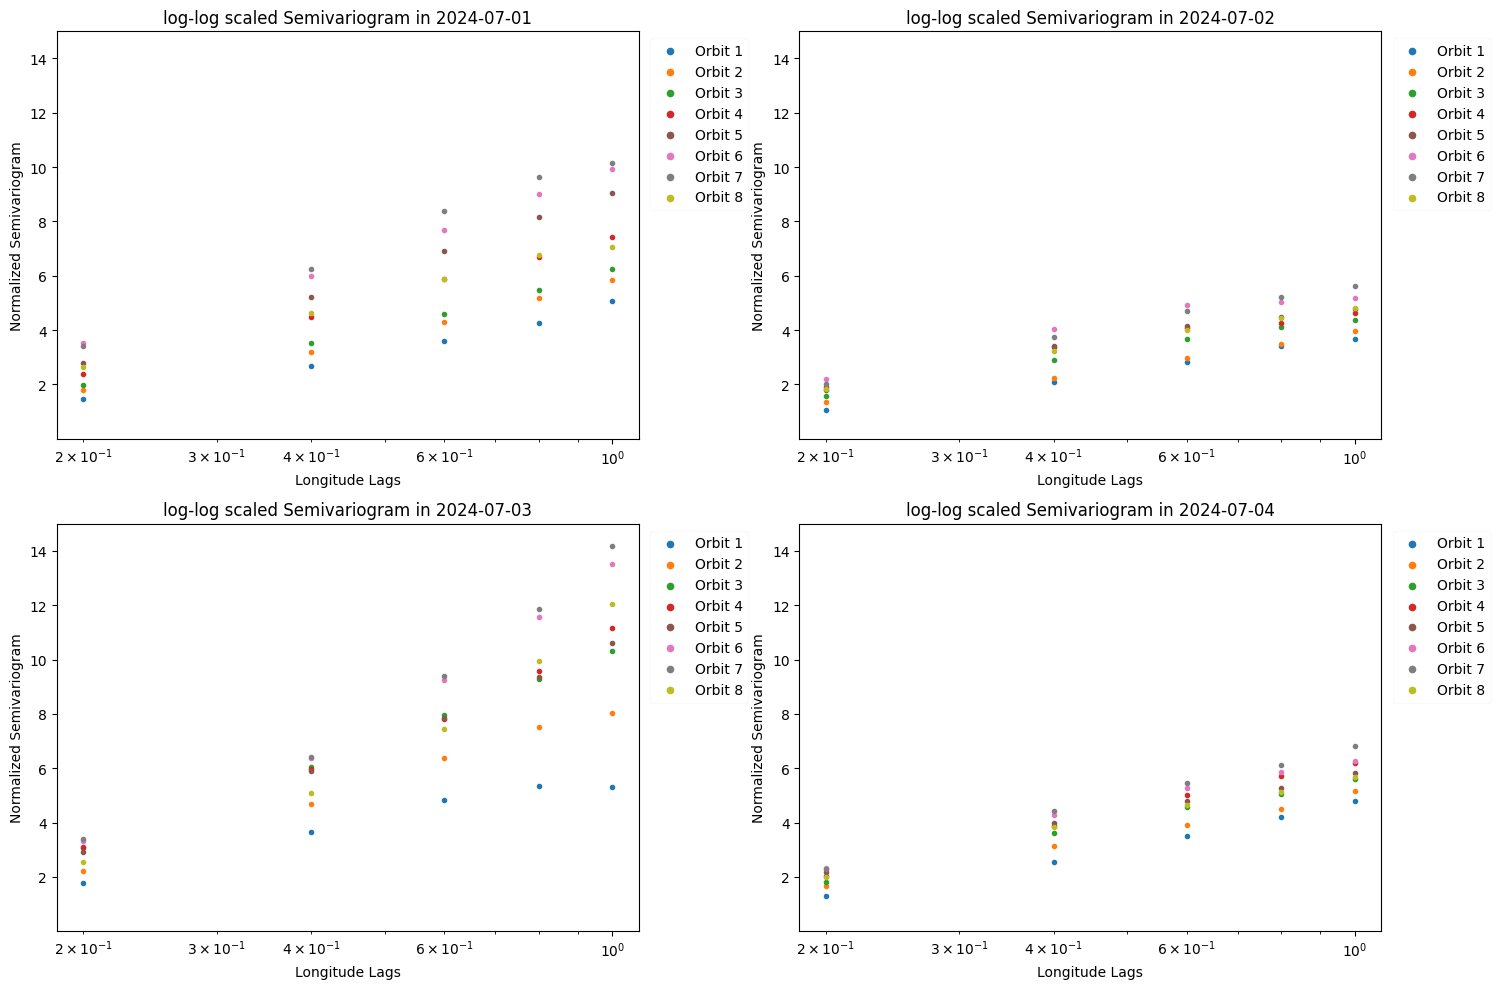

In [120]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist, squareform

# Assuming `ori_semi_var_timeseries` and `lags` are defined earlier
cmap = plt.get_cmap('tab10', 9)  # Choose a colormap
days =  [1,2,3,4]  # Example days you want to plot
map = sparse_map_24_7
tolerance = 0.02
# Define 2D lags for latitude and longitude
deltas = [(0,0), (0, 0.2), (0, 0.4), (0, 0.6), (0, 0.8), (0, 1) ]

# Create a 2x2 plot
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for index, day in enumerate(days):
    t = day - 1
    ori_semi_var_timeseries = [[0] * len(deltas) for _ in range(8)]
    key_list = sorted(map)

    for i in range(8 * t, 8 * t + 8):
        cur_data = map[key_list[i]]
        coordinates = np.array(cur_data[['Latitude', 'Longitude']])
        values = np.array(cur_data['ColumnAmountO3']) - np.mean(np.array(cur_data['ColumnAmountO3']))

        # Calculate pairwise differences in both latitude and longitude
        lat_diffs = coordinates[:, None, 0] - coordinates[None, :, 0]
        lon_diffs = coordinates[:, None, 1] - coordinates[None, :, 1]
        # Calculate the pairwise distances between all points
       
        for j, (delta_lat, delta_lon) in enumerate(deltas):

            valid_pairs = np.where(
                (np.abs(lat_diffs - delta_lat) <= tolerance) & 
                (np.abs(lon_diffs - delta_lon) <= tolerance)
            )

            if len(valid_pairs[0]) == 0:
                print(f"No valid pairs found for t{j+1:02d}_{i+1} at delta ({delta_lat}, {delta_lon})")
                ori_semi_var_timeseries[i % 7][j] = np.nan
                continue

            # Compute the semivariance for those valid pairs
            semivariances = 0.5 * np.mean((values[valid_pairs[0]] - values[valid_pairs[1]]) ** 2)

            # Normalize the semivariance
            variance_of_data = np.var(values)
            normalized_semivariance = semivariances / variance_of_data
            normalized_semivariance = semivariances
            # Append the normalized semivariance to the timeseries
            ori_semi_var_timeseries[i % 8][j] = normalized_semivariance

    # Plotting all orbits for the current day
    ax = axs[index // 2, index % 2]

    x_values = []
    for j, (lat, lon) in enumerate(deltas):
        if lat < 0 or lon < 0:
            x_values.append(lon )  # Use negative index for negative lags
        else:
            x_values.append(lon)   # Use positive index for positive lags

    for i in range(8):
        color = cmap(i / 9)
        ax.scatter(x_values, ori_semi_var_timeseries[i], marker='o', s=9, color=color, label=f'Orbit {i + 1}')
    ax.legend(loc='upper right', markerscale=1.5, framealpha=0.1, bbox_to_anchor=(1.2,1.0))
    ax.set_xlabel('Longitude Lags')
    ax.set_ylabel('Normalized Semivariogram')
    ax.set_title(f'log-log scaled Semivariogram in 2024-07-{day:02d}')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylim(1e-4,15)
plt.tight_layout()
plt.show()

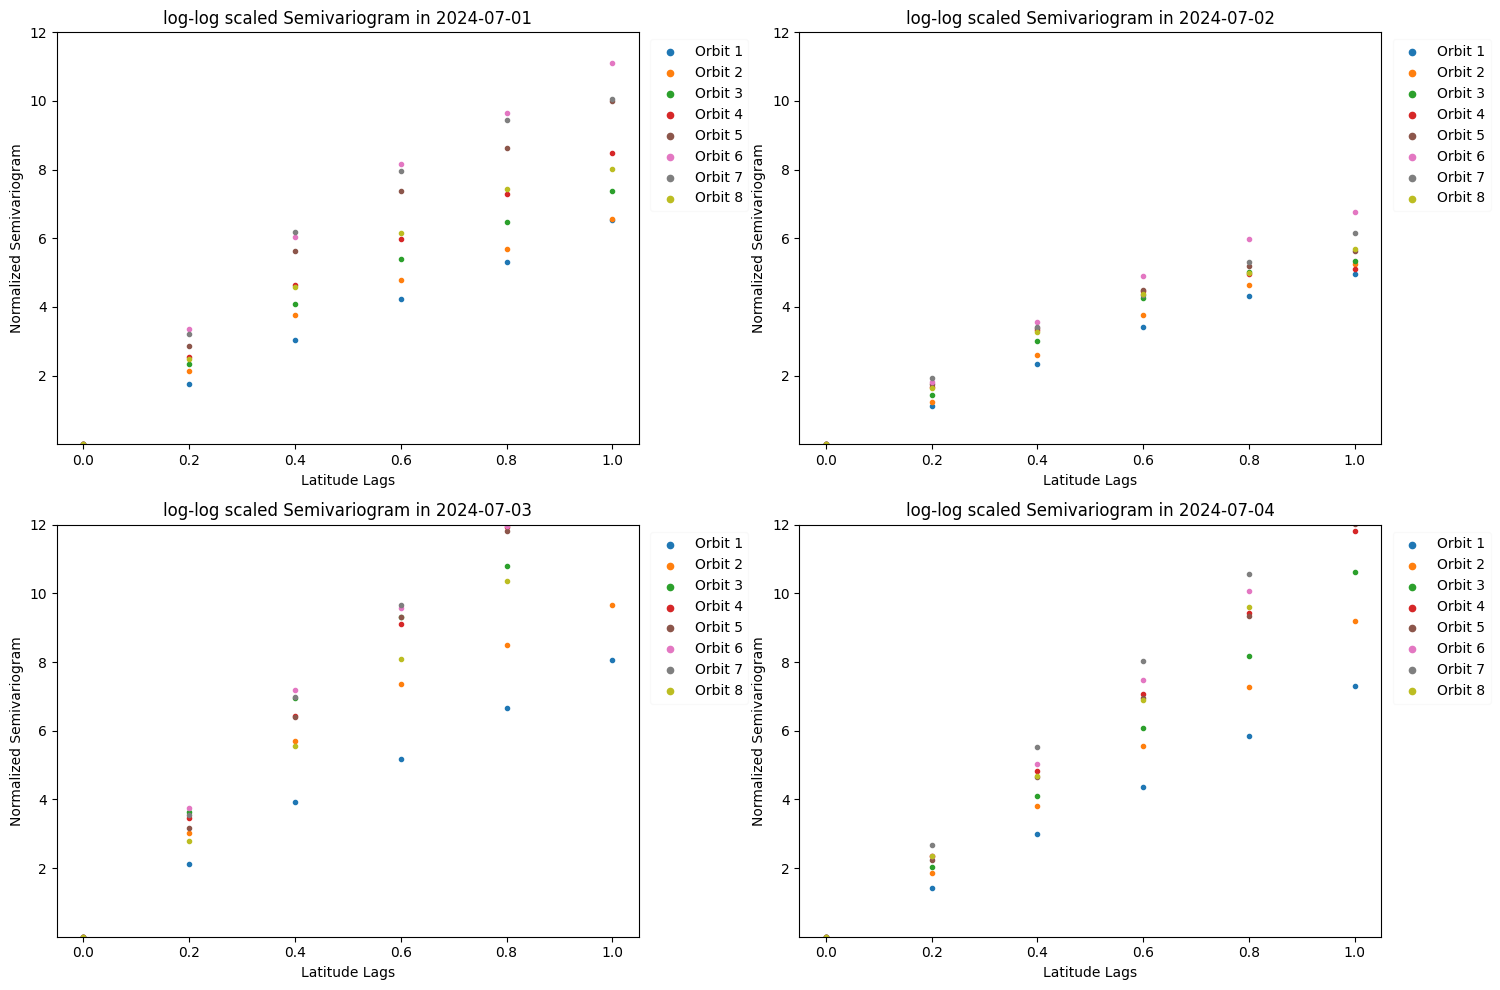

In [121]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist, squareform

# Assuming `ori_semi_var_timeseries` and `lags` are defined earlier
cmap = plt.get_cmap('tab10', 9)  # Choose a colormap
days = [1,2,3,4]  # Example days you want to plot
map = sparse_map_24_7
tolerance = 0.02
# Define 2D lags for latitude and longitude
deltas = [(0,0), (0.2, 0), (0.4, 0), (0.6, 0), (0.8, 0), (1, 0)]

# Create a 2x2 plot
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for index, day in enumerate(days):
    t = day - 1
    ori_semi_var_timeseries = [[0] * len(deltas) for _ in range(8)]
    key_list = sorted(map)

    for i in range(8 * t, 8 * t + 8):
        cur_data = map[key_list[i]]
        coordinates = np.array(cur_data[['Latitude', 'Longitude']])
        values = np.array(cur_data['ColumnAmountO3']) - np.mean( np.array(cur_data['ColumnAmountO3'])      )

        # Calculate pairwise differences in both latitude and longitude
        lat_diffs = coordinates[:, None, 0] - coordinates[None, :, 0]
        lon_diffs = coordinates[:, None, 1] - coordinates[None, :, 1]

        # Calculate the pairwise distances between all points
       

        for j, (delta_lat, delta_lon) in enumerate(deltas):

            valid_pairs = np.where(
                (np.abs(lat_diffs - delta_lat) <= tolerance) & 
                (np.abs(lon_diffs - delta_lon) <= tolerance)
            )

            if len(valid_pairs[0]) == 0:
                print(f"No valid pairs found for t{j+1:02d}_{i+1} at delta ({delta_lat}, {delta_lon})")
                ori_semi_var_timeseries[i % 8][j] = np.nan
                continue

            # Compute the semivariance for those valid pairs
            semivariances = 0.5 * np.mean((values[valid_pairs[0]] - values[valid_pairs[1]]) ** 2)

            # Normalize the semivariance
            variance_of_data = np.var(values)
            normalized_semivariance = semivariances / variance_of_data
            normalized_semivariance = semivariances
            
            # Append the normalized semivariance to the timeseries
            ori_semi_var_timeseries[i % 8][j] = normalized_semivariance

    # Plotting all orbits for the current day
    ax = axs[index // 2, index % 2]
    x_values = []
    for j, (lat, lon) in enumerate(deltas):
        if lat < 0 or lon < 0:
            x_values.append(lat)  # Use negative index for negative lags
        else:
            x_values.append(lat)   # Use positive index for positive lags

    for i in range(8):
        color = cmap(i / 9)
        ax.scatter(x_values, ori_semi_var_timeseries[i], marker='o', s=9, color=color, label=f'Orbit {i + 1}')
        
    ax.legend(loc='upper right', markerscale=1.5, framealpha=0.1, bbox_to_anchor=(1.2,1.0))
    ax.set_xlabel('Latitude Lags')
    ax.set_ylabel('Normalized Semivariogram')
    ax.set_title(f'log-log scaled Semivariogram in 2024-07-{day:02d}')
    
    ax.set_xscale('linear')
    ax.set_yscale('linear')
    ax.set_ylim(1e-4,12)

plt.tight_layout()
plt.show()

### SEMIVARIOGRAM LONGITUDE LAG PLOT, LATITUDE LAG PLOT AT ONCE

2024-11-10 Note:
I didn't normalize semivariogram.

# test

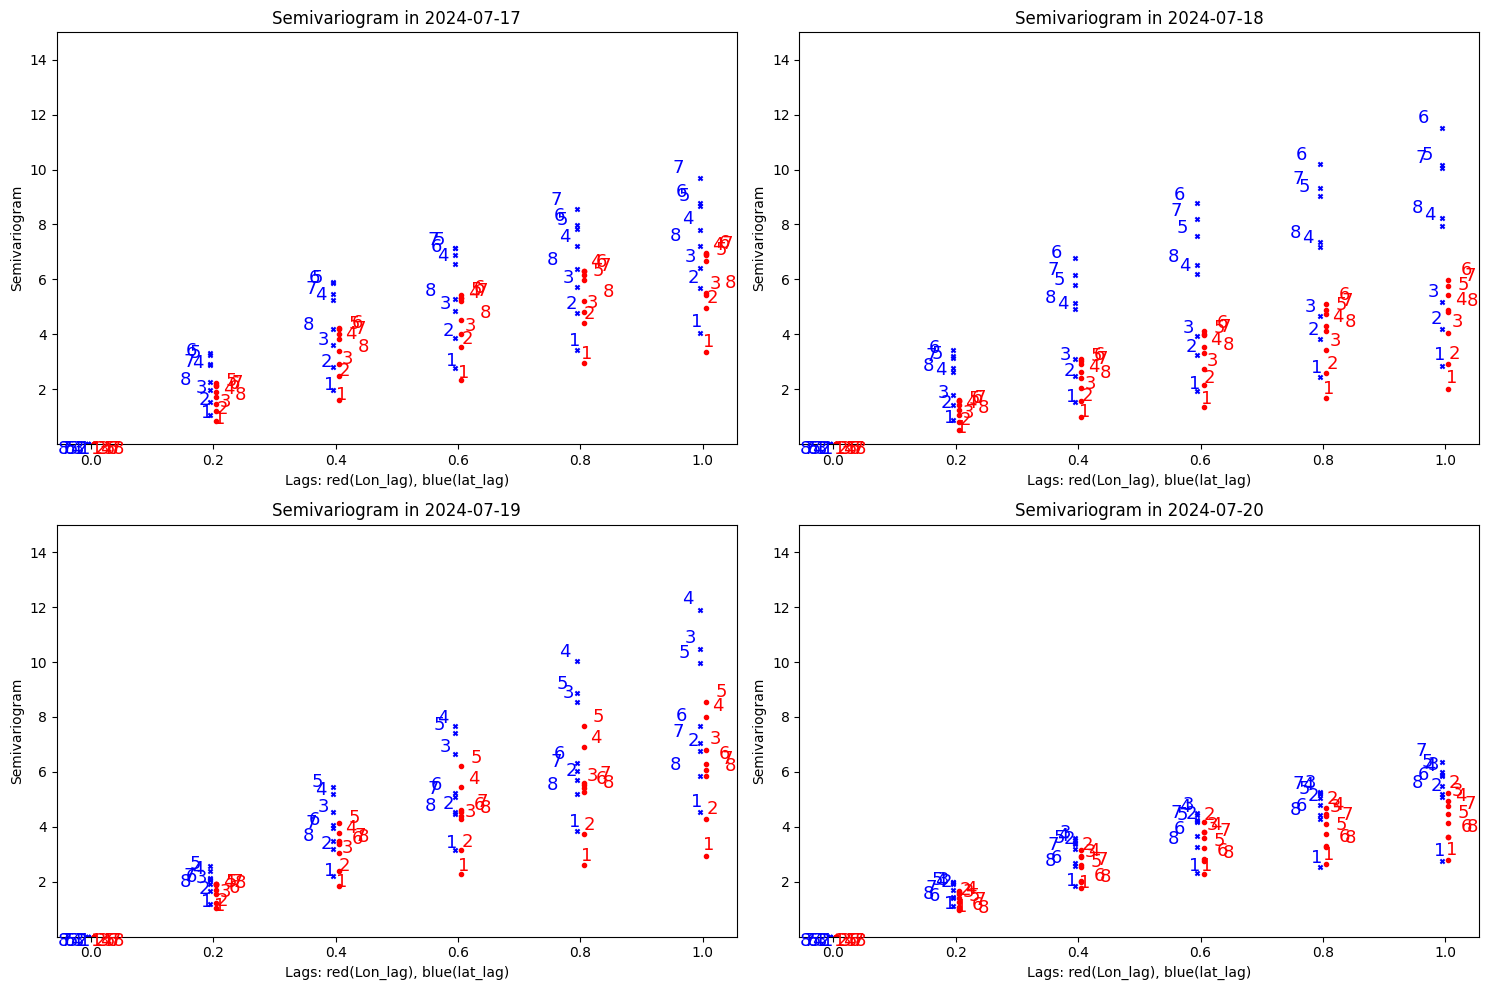

In [160]:
# Assuming `ori_semi_var_timeseries` and `lags` are defined earlier
cmap = plt.get_cmap('viridis', 9)  # Choose a colormap
days = [17,18,19,20]  # Example days you want to plot
map = sparse_map_24_7
tolerance = 0.02
# Define 2D lags for latitude and longitude
deltas = [(0,0),(0, 0.2), (0, 0.4), (0, 0.6), (0, 0.8), (0, 1) ]
deltas2 = [(0,0),(0.2, 0), (0.4, 0), (0.6, 0), (0.8, 0), (1, 0)]

# Create a 2x2 plot
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for index, day in enumerate(days):
    t = day - 1
    ori_semi_var_timeseries = [[0] * len(deltas) for _ in range(8)]
    ori_semi_var_timeseries2 = [[0] * len(deltas) for _ in range(8)]
    key_list = sorted(map)

    for i in range(8 * t, 8 * t + 8):
        cur_data = map[key_list[i]]
        coordinates = np.array(cur_data[['Latitude', 'Longitude']])
        values = np.array(cur_data['ColumnAmountO3']) - np.mean(np.array(cur_data['ColumnAmountO3']))

        # Calculate pairwise differences in both latitude and longitude
        lat_diffs = coordinates[:, None, 0] - coordinates[None, :, 0]
        lon_diffs = coordinates[:, None, 1] - coordinates[None, :, 1]

        # Calculate the pairwise distances between all points
       

        for j, (delta_lat, delta_lon) in enumerate(deltas):

            valid_pairs = np.where(
                (np.abs(lat_diffs - delta_lat) <= tolerance) & 
                (np.abs(lon_diffs - delta_lon) <= tolerance)
            )

            if len(valid_pairs[0]) == 0:
                print(f"No valid pairs found for t{j+1:02d}_{i+1} at delta ({delta_lat}, {delta_lon})")
                ori_semi_var_timeseries[i % 8][j] = np.nan
                continue

            # Compute the semivariance for those valid pairs
            semivariances = 0.5 * np.mean((values[valid_pairs[0]] - values[valid_pairs[1]]) ** 2)

            # Normalize the semivariance
            variance_of_data = np.var(values)
            normalized_semivariance = semivariances / variance_of_data
            normalized_semivariance = semivariances

            # Append the normalized semivariance to the timeseries
            ori_semi_var_timeseries[i % 8][j] = normalized_semivariance

        for j, (delta_lat, delta_lon) in enumerate(deltas2):

            valid_pairs2 = np.where(
                (np.abs(lat_diffs - delta_lat) <= tolerance) & 
                (np.abs(lon_diffs - delta_lon) <= tolerance)
            )
            
            semivariances2 = 0.5 * np.mean((values[valid_pairs2[0]] - values[valid_pairs2[1]]) ** 2)
            normalized_semivariance2 = semivariances2 / variance_of_data
            normalized_semivariance2 = semivariances2
            ori_semi_var_timeseries2[i % 8][j] = normalized_semivariance2


    # Plotting all orbits for the current day
    ax = axs[index // 2, index % 2]

    x_values = []
    for j, (lat, lon) in enumerate(deltas):
        if lat < 0 or lon < 0:
            x_values.append(lon )  # Use negative index for negative lags
        else:
            x_values.append(lon)   # Use positive index for positive lags
    x_values2 = []
    for j, (lat, lon) in enumerate(deltas2):
        if lat < 0 or lon < 0:
            x_values2.append(lat )  # Use negative index for negative lags
        else:
            x_values2.append(lat)   # Use positive index for positive lags  
    x_values = [x + 0.005 for x in x_values]              
    x_values2 = [x - 0.005 for x in x_values2]
    for i in range(8):
        color = cmap(i / 9)

        weight = [-0.5, -0.25, -0.15, -0.05, 0, 0.05, 0.15, 0.25, 0.5]
        weight2 = [0.01,0.02, 0.03, 0.04, 0.05, 0.06, 0.07,0.08]

        min_y1 = min(ori_semi_var_timeseries[i])
        min_y2 = min(ori_semi_var_timeseries2[i])
        # Plot longitude lags (red points with numbers)
        for j, (x, y) in enumerate(zip(x_values, ori_semi_var_timeseries[i])):
            ax.scatter(x, y, marker='o', s=9, color= 'red')
            ax.text(x+ weight2[i]*0.5, y + weight[j], str(i + 1), fontsize=13, color='red', ha='center', va='bottom')

        # Plot latitude lags (blue points with numbers)
        for j, (x, y) in enumerate(zip(x_values2, ori_semi_var_timeseries2[i])):
            ax.scatter(x, y, marker='x', s=9, color='blue')
            ax.text(x- weight2[i]*0.5, y + weight[j], str(i + 1), fontsize=13, color='blue', ha='center', va='bottom')
    
    # ax.legend(loc='upper right', markerscale=1.5, framealpha=0.1, bbox_to_anchor=(1.2,1.0))
    ax.set_xlabel('Lags: red(Lon_lag), blue(lat_lag)')
    # ax.set_ylabel('Normalized Semivariogram')
    ax.set_ylabel('Semivariogram')
    ax.set_title(f'Semivariogram in 2024-07-{day:02d}')
    # ax.set_title(f'log-log scaled Semivariogram in 2024-07-{day:02d}')
    
    ax.set_xscale('linear')
    ax.set_yscale('linear')
    ax.set_ylim(1e-4,15)

plt.tight_layout()
plt.show()



# Cross variograms

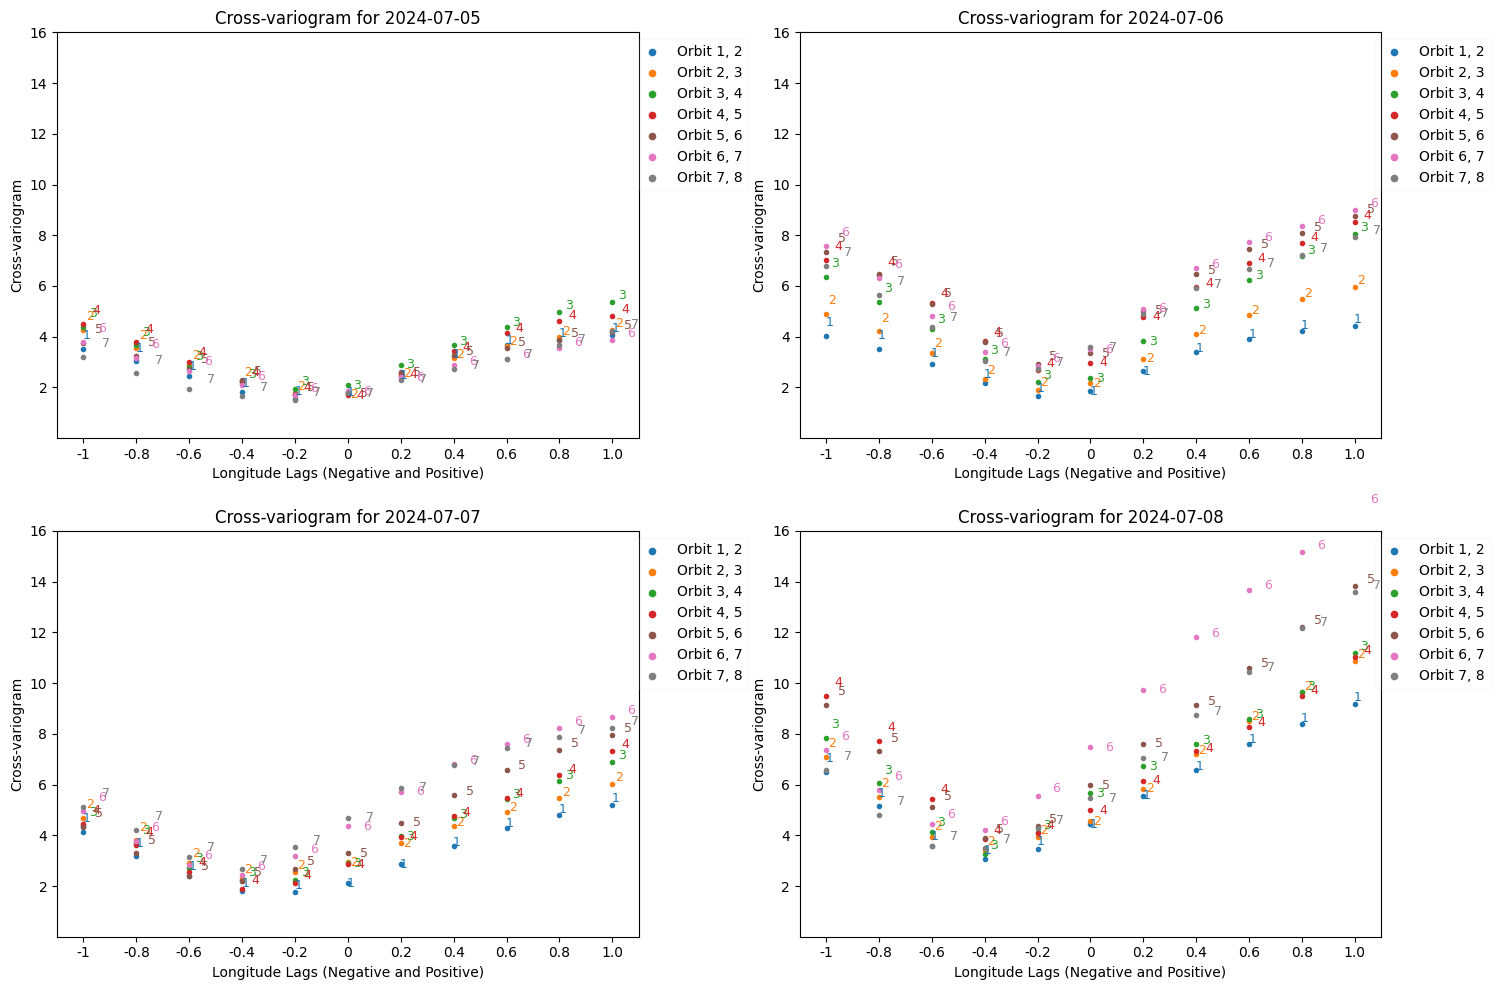

In [158]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist, squareform

# Assuming `ori_semi_var_timeseries` and `lags` are defined earlier
cmap = plt.get_cmap('tab10', 9)  # Choose a colormap
days = [5,6,7,8]  # Example days you want to plot
map = sparse_map_24_7
tolerance = 0.02
# Define 2D lags for latitude and longitude

deltas = [(0,0), (0, 0.2), (0, 0.4), (0, 0.6), (0, 0.8), (0, 1) ]
# Include negative deltas
deltas += [(d[0], -d[1]) for d in deltas if d[1] != 0] + [(-d[0], d[1]) for d in deltas if d[0] != 0]

# Create a 2x2 plot
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for index, day in enumerate(days):
    t = day - 1
    ori_semi_var_timeseries = [[0] * len(deltas) for _ in range(7)]
    key_list = sorted(map)

    for i in range(8 * t, 8 * t + 7):         # change 7 to 6
        cur_data = map[key_list[i]]
        next_data = map[key_list[i+1]]
        coordinates = np.array(cur_data[['Latitude', 'Longitude']])
        cur_values = np.array(cur_data['ColumnAmountO3']) - np.mean(np.array(cur_data['ColumnAmountO3']))
        next_values = np.array(next_data['ColumnAmountO3']) - np.mean( np.array(next_data['ColumnAmountO3'])  )
        # Calculate pairwise differences in both latitude and longitude
        lat_diffs = coordinates[:, None, 0] - coordinates[None, :, 0]
        lon_diffs = coordinates[:, None, 1] - coordinates[None, :, 1]

        # Calculate the pairwise distances between all points
       
        for j, (delta_lat, delta_lon) in enumerate(deltas):

            valid_pairs = np.where(
                (np.abs(lat_diffs + delta_lat) <= tolerance) & 
                (np.abs(lon_diffs + delta_lon) <= tolerance)
            )

            if len(valid_pairs[0]) == 0:
                print(f"No valid pairs found for t{j+1:02d}_{i+1} at delta ({delta_lat}, {delta_lon})")
                ori_semi_var_timeseries[i % 8][j] = np.nan
                continue
            # Compute the semivariance for those valid pairs
            semivariances = 0.5 * np.mean(( next_values[valid_pairs[1]] - cur_values[valid_pairs[0]]  ) ** 2)

            # Normalize the semivariance
            variance_of_data = np.var(values)
            normalized_semivariance = semivariances 

            # Append the normalized semivariance to the timeseries
            ori_semi_var_timeseries[i % 8][j] = normalized_semivariance

    # Plotting all orbits for the current day
    ax = axs[index // 2, index % 2]
    # Separate positive and negative lags and assign appropriate indices
    x_values = []
    scale_factor =1
    for j, (lat, lon) in enumerate(deltas):
        if lat < 0 or lon < 0:
            x_values.append(lon )  # Use negative index for negative lags
        else:
            x_values.append(lon)   # Use positive index for positive lags


    weight = [-0.55, -0.5, -0.25, -0.15, -0.05, 0,    0.05, 0.15, 0.25, 0.5 ,0.55]
    weight2 = [0.01, 0.02,  0.03,  0.04, 0.05, 0.06, 0.07, 0.08]
    # Plotting for each orbit

    for i in range(7):
        color = cmap(i / 9)

        for j, (x, y) in enumerate(zip(x_values, ori_semi_var_timeseries[i])):
            if j==0:
                ax.scatter(x, y, marker='o', s=9, color= color, label=f'Orbit {i + 1}, {i + 2}')
                ax.text(x+ weight2[i]*1.2, y + weight[j]*0.5  , str(i + 1), fontsize=9, color=color, ha='center', va='bottom')
            else:
                ax.scatter(x, y, marker='o', s=9, color= color)
                ax.text(x+ weight2[i]*1.2, y + weight[j]*0.5 , str(i + 1), fontsize=9, color=color, ha='center', va='bottom')

    ax.legend(loc='upper right', markerscale=1.5, framealpha=0.1, bbox_to_anchor=(1.2,1.0))
    # ax.legend(loc='upper right', markerscale=1.5, framealpha=0.3)
    ax.set_xlabel('Longitude Lags (Negative and Positive)')
    ax.set_ylabel('Cross-variogram')
    ax.set_title(f'Cross-variogram for 2024-07-{day:02d}')
    ax.set_xscale('linear')  # Linear scale for x-axis
    ax.set_yscale('linear')  # Linear scale for y-axis
# Set custom x-axis ticks a
    ax.set_xticks([-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0]) 
    ax.set_xticklabels(['-1', '-0.8', '-0.6', '-0.4', '-0.2', '0' ,'0.2', '0.4', '0.6', '0.8', '1.0'])
    ax.set_ylim(1e-4,16)

plt.tight_layout()
plt.show()



Latitude lag crossvariogram

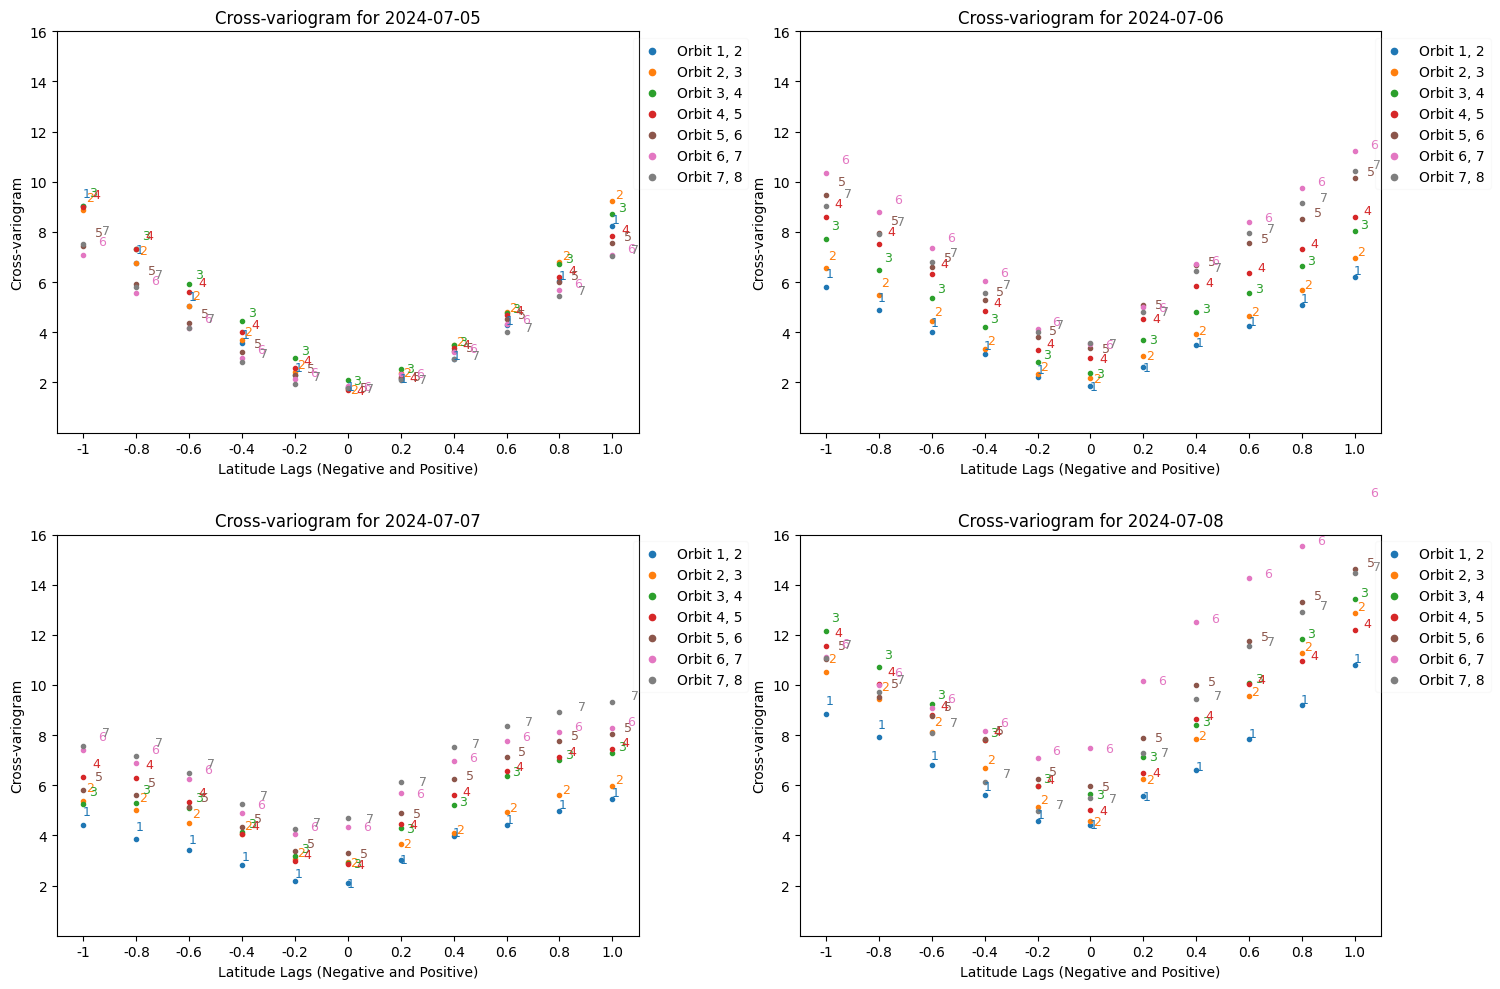

In [159]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial.distance import pdist, squareform

# Assuming `ori_semi_var_timeseries` and `lags` are defined earlier
cmap = plt.get_cmap('tab10', 9)  # Choose a colormap
days = [5,6,7,8]  # Example days you want to plot
map = sparse_map_24_7
tolerance = 0.02
# Define 2D lags for latitude and longitude
deltas = [ (0,0), (0.2, 0), (0.4, 0), (0.6, 0), (0.8, 0), (1, 0)]
# Include negative deltas
deltas += [(d[0], -d[1]) for d in deltas if d[1] != 0] + [(-d[0], d[1]) for d in deltas if d[0] != 0]

# Create a 2x2 plot
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for index, day in enumerate(days):
    t = day - 1
    ori_semi_var_timeseries = [[0] * len(deltas) for _ in range(7)]
    key_list = sorted(map)

    for i in range(8 * t, 8 * t + 7):         # change 7 to 6
        cur_data = map[key_list[i]]
        next_data = map[key_list[i+1]]
        coordinates = np.array(cur_data[['Latitude', 'Longitude']])
        cur_values = np.array(cur_data['ColumnAmountO3']) - np.mean(np.array(cur_data['ColumnAmountO3']))
        next_values = np.array(next_data['ColumnAmountO3']) - np.mean( np.array(next_data['ColumnAmountO3'])  )
        # Calculate pairwise differences in both latitude and longitude
        lat_diffs = coordinates[:, None, 0] - coordinates[None, :, 0]
        lon_diffs = coordinates[:, None, 1] - coordinates[None, :, 1]

        # Calculate the pairwise distances between all points
       

        for j, (delta_lat, delta_lon) in enumerate(deltas):

            valid_pairs = np.where(
                (np.abs(lat_diffs - delta_lat) <= tolerance) & 
                (np.abs(lon_diffs - delta_lon) <= tolerance)
            )

            if len(valid_pairs[0]) == 0:
                print(f"No valid pairs found for t{j+1:02d}_{i+1} at delta ({delta_lat}, {delta_lon})")
                ori_semi_var_timeseries[i % 8][j] = np.nan
                continue

            # Compute the semivariance for those valid pairs
            semivariances = 0.5 * np.mean((cur_values[valid_pairs[0]] - next_values[valid_pairs[1]]) ** 2)
            
            # Normalize the semivariance
            # variance_of_data = np.var(values)
            # normalized_semivariance = semivariances / variance_of_data

            # Append the normalized semivariance to the timeseries
            ori_semi_var_timeseries[i % 8][j] = semivariances

    # Plotting all orbits for the current day
    ax = axs[index // 2, index % 2]
    # Separate positive and negative lags and assign appropriate indices
    x_values = []
    for j, (lat, lon) in enumerate(deltas):
        if lat < 0 or lon < 0:
            x_values.append(lat)  # Use negative index for negative lags
        else:
            x_values.append(lat)   # Use positive index for positive lags


    weight = [-0.55, -0.5, -0.25, -0.15, -0.05, 0,    0.05, 0.15, 0.25, 0.5 ,0.55]
    weight2 = [0.01, 0.02,  0.03,  0.04, 0.05, 0.06, 0.07, 0.08]
    # Plotting for each orbit

    for i in range(7):
        color = cmap(i / 9)

        for j, (x, y) in enumerate(zip(x_values, ori_semi_var_timeseries[i])):
            if j==0:
                ax.scatter(x, y, marker='o', s=9, color= color, label=f'Orbit {i + 1}, {i + 2}')
                ax.text(x+ weight2[i]*1.2, y + weight[j]*0.5  , str(i + 1), fontsize=9, color=color, ha='center', va='bottom')
            else:
                ax.scatter(x, y, marker='o', s=9, color= color)
                ax.text(x+ weight2[i]*1.2, y + weight[j]*0.5 , str(i + 1), fontsize=9, color=color, ha='center', va='bottom')
        
    ax.legend(loc='upper right', markerscale=1.5, framealpha=0.1, bbox_to_anchor=(1.2,1.0))
    ax.set_xlabel('Latitude Lags (Negative and Positive)')
    ax.set_ylabel('Cross-variogram')
    ax.set_title(f'Cross-variogram for 2024-07-{day:02d}')
    ax.set_xscale('linear')  # Linear scale for x-axis
    ax.set_yscale('linear')  # Linear scale for y-axis
# Set custom x-axis ticks a
    ax.set_xticks([-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0]) 
    ax.set_xticklabels(['-1', '-0.8', '-0.6', '-0.4', '-0.2', '0' ,'0.2', '0.4', '0.6', '0.8', '1.0'])
    ax.set_ylim(1e-4,16)

plt.tight_layout()
plt.show()